# Deep Feature Interpolation

## Описание задания

В этом задании вы ознакомитесь с довольно простым, но очень интересным подходом для семантической модификации (морфирования) изображений. От вас потребуется реализовать основные компоненты этого алгоритма с использованием библиотеки TensorFlow. В качестве логического завершения задания, вы напишете свой мини-аналог приложения FaceApp. Вам будут даны все  необходимые данные. Предполагается, что для выполнения задания не потребуется GPU.

### Ожидаемые результаты

В этом задании (как и в оригинальной статье) мы будем проводить эксперименты с лицами людей. При корректном выполнении задания, вы сможете генерировать похожие изображения:

![female](./example-results/female.png)
![g&m](./example-results/g&m.png)
![old](./example-results/old.png)

## Шаг 0: изучение статьи

Как и при решении любой другой задачи, связанной с обучением глубоких сетей, первым делом стоит разобраться в деталях реализуемого алгоритма. По этой [ссылке](https://arxiv.org/abs/1611.05507) вы найдете статью, которую нужно изучить. После изучения  вы должны иметь возможность ответить себе на следующие вопросы:

1. Какая задача решается? Какие данные для этого нужны? Какие требования к модели?
2. Каким образом получается векторное представление нашего изображения?
3. Как получить вектор сдвига, удовлетворяющий нашим требованиям?
4. Как лучше всего подбирать изображения-кандидаты?
5. Какой функционал мы минимизируем? Каким образом?
6. Как можно улучшить качество результата (убрать артефакты)?

In [1]:
# Install these packages:

# conda create -n dfi python=3.5
# conda install jupyter
# source activate dfi
# jupyter notebook

import tensorflow as tf      # conda install tensorflow[-gpu]
from PIL import Image        # conda install pillow
from tqdm import tqdm        # conda install tqdm
import numpy as np           # conda install numpy
import cv2                   # conda install -c menpo opencv
import os

import matplotlib.pyplot as plt # conda install matplotlib
%matplotlib inline

## Шаг 1: загрузка данных

### Описание базы

Специально для этого задания была создана база, состоящая более чем из 200K изображений лиц, имеющих разметку по возрасту, полу, расе, типу растительности на лице и типу надетых очков. Разметка была получена в автоматическом режиме при помощи имеющейся модели. Хоть эта база и содержит ошибки, используя её, можно получить очень хороший результат.

Все изображения лиц были выровненые с использованием стороннего инструмента. Кропы лиц были получены при помощи детектора лиц OpenCV.

### Загрузка базы

Для выполнения задания вам потребуется загрузить этот датасет себе на компьютер. Ссылки для скачивания вам должен был предоставить тот, кто выдал вам это задание. Скачав архив себе на комьютер, разархивируйте его. Данный имеют следующий формат: 
 * директория `images` содержит JPEG изображениями лиц (уже подготовленные)
 * текстовый файл `gt.csv` содержит разметкой для этих изображений
 * директория `params` хранит вспомогательные файлы

Загрузим разметку. В коде ниже не забудьте указать вернуть путь к директории базы.

In [2]:
def load_dataset(directory):
    header = []
    labels = []
    filepaths = []
    
    with open(os.path.join(directory, 'gt.csv')) as f:
        header = f.readline().strip().split()[1:]
        header = [h.lower() for h in header]
        for line in f:
            fields = line.strip().split()
            path = os.path.join(directory, fields[0])
            filepaths.append(path)
            labels.append(fields[1:])

    return (
        header,
        np.array(labels),
        np.array(filepaths)
    )

# Set path to dataset on your computer
DATASET_DIRECTORY_PATH = './data'  
header, labels, filepaths = load_dataset(DATASET_DIRECTORY_PATH)

### Обзор атрибутов

Для понимания, какие атрибуты вам доступны и в каком количестве, посмотрите на круговые диаграммы ниже. Они описывают  распределение значений таких атрибутов как **раса**, **пол**, **тип очков** и **тип растительности на лице**, а так же посмотрите на столбцовую диаграмму, описывающую распределение людей **по возрастам**. Как видно, некоторые значения атрибутов встречаются в базе редко, поэтому учитывайте это при работе с алгоритмом.

![attributes](./stats/attributes.png)
![ages](./stats/ages.png)

Отлично. Данные готовы. Для удобной работы с ними реализуем служебные функции. Функция `get_mask` даст нам возможность удобно работать с подвыборками нашей базы.

In [3]:
def get_mask(**kwargs):
    mask = np.ones(len(filepaths), dtype=np.bool)
    for h in kwargs:
        if isinstance(kwargs[h], list):
            mask &= np.in1d(labels[:, header.index(h)], kwargs[h])
        else:
            mask &= labels[:, header.index(h)] == kwargs[h]
    return mask

def load_image(path, size=(128, 128)):
    img = Image.open(path)
    img = img.convert("RGB")
    img = img.resize(size, Image.BICUBIC)
    return img

def image_to_tensor(image):
    return np.float32(np.array(image) / 255.0)[np.newaxis, :, :, :]

def tensor_to_image(tensor):
    return Image.fromarray(np.uint8(tensor[0] * 255.0))

## Шаг 2: реализация модели

Для вашего удобства в коде ниже приведено почти полное описание модели, с которой мы будем работать. Это VGG-16, предобученная на ImageNet. Несмотря на то, что на данный момент более современные архитектуры во многих задачах превосходят её по скорости и точности (например, ResNet), VGG до сих пор может применяться в задачах, где нужно извлекать интепретируемые признаки, например, для переноса стиля.

### Задача

Функция построения архитектуры и загрузки весов модели уже реализована (не забудьте указать путь к файлу с весами модели `weights.npy`, прилагающийся к архиву). Пока эта функция не возращает тензор, соответствующего вектор-признаку, который нужен нашему алгоритму. **Напишите необходимый код, чтобы функция его вернула.**

In [4]:
PATH_TO_VGG_WEIGHTS_FILE = './data/params/weights.npy'
weights_init = np.load(PATH_TO_VGG_WEIGHTS_FILE).item()
channel_mean = np.array([103.939, 116.779, 123.68])


def phi(z):
    image = z * 255.0
    red, green, blue = tf.split(image, 3, axis=3)
    data = tf.concat([
        blue - channel_mean[0],
        green - channel_mean[1],
        red - channel_mean[2],
    ], 3, name='image_preprocessed')
    
    def max_pool(x, name):
        return tf.nn.max_pool(
            x, name=name,
            ksize=[1, 2, 2, 1], 
            strides=[1, 2, 2, 1], 
            padding='SAME')

    def conv_layer(x, name):
        weights = tf.constant(weights_init[name][0], name="weights")
        biases = tf.constant(weights_init[name][1], name="biases")
        x = tf.nn.conv2d(x, weights, [1, 1, 1, 1], padding='SAME')
        x = tf.nn.bias_add(x, biases)
        x = tf.nn.relu(x)
        return x

    conv1_1 = conv_layer(data, "conv1_1")
    conv1_2 = conv_layer(conv1_1, "conv1_2")
    pool1 = max_pool(conv1_2, 'pool1') 
    # -> 112x112x64

    conv2_1 = conv_layer(pool1, "conv2_1")
    conv2_2 = conv_layer(conv2_1, "conv2_2")
    pool2 = max_pool(conv2_2, 'pool2') 
    # -> 56x56x128

    conv3_1 = conv_layer(pool2, "conv3_1")
    conv3_2 = conv_layer(conv3_1, "conv3_2")
    conv3_3 = conv_layer(conv3_2, "conv3_3")
    conv3_4 = conv_layer(conv3_3, "conv3_4")
    pool3 = max_pool(conv3_4, 'pool3') 
    # -> 28x28x256

    conv4_1 = conv_layer(pool3, "conv4_1")
    conv4_2 = conv_layer(conv4_1, "conv4_2")
    conv4_3 = conv_layer(conv4_2, "conv4_3")
    conv4_4 = conv_layer(conv4_3, "conv4_4")
    pool4 = max_pool(conv4_4, 'pool4') 
    # -> 14x14x512

    conv5_1 = conv_layer(pool4, "conv5_1")
    conv5_2 = conv_layer(conv5_1, "conv5_2")
    conv5_3 = conv_layer(conv5_2, "conv5_3")
    conv5_4 = conv_layer(conv5_3, "conv5_4")
    pool5 = max_pool(conv5_4, 'pool5') 
    # -> 7x7x512

    return tf.concat([tf.contrib.layers.flatten(conv3_1)[0], tf.contrib.layers.flatten(conv4_1)[0], tf.contrib.layers.flatten(conv5_1)[0]], axis=0)

## Шаг 3: реализация функции потерь

Далее нам потребуется реализовать функцию потерь для нашей задачи. Как вам должно быть известно, эта функция зависит от самого изображения, от его вектор-признака и от целевого-вектор признака.

### Задача

**Реализуйте функцию ниже, чтобы она возращала тензор нулевого порядка (скаляр), соответствующий значению функции потерь.**

In [5]:
def dfi_loss(z, phi_z, phi_x_shifted):
    height_diff = z[:, :, :-1, :-1] - z[:, :, :-1, 1:]
    width_diff = z[:, :, :-1, :-1] - z[:, :, 1:, :-1]
    return (0.5*tf.reduce_mean(tf.square(phi_z - phi_x_shifted)) + 
        1e-3*(tf.reduce_mean(tf.square(height_diff)) + tf.reduce_mean(tf.square(width_diff))))

## Шаг 4: задание оптимизатора

### Задача

**Реализуйте функцию, которая получает на вход значение функционала потерь и изображение, по которому мы будем производить оптимизацию.** 

На выходе эта функция должна возращать оператор, вызывая который происходит один шаг градиентного спуска (разберитесь, как работать с оптимизаторами в Tensorflow). Политику learning rate реализуйте на ваше усмотрение.

Может получиться так, что в TensorFlow не будет нужного оптимизатора. В этом случае выберите оптимизатор, опираясь на интуицию.

In [6]:
def setup_optimizer(loss, z):
    opt = tf.train.GradientDescentOptimizer(1e-4)
    return opt.minimize(loss, var_list=[z])

## Шаг 5: описание переменных и операций над ними

До этого мы реализовали, функции, которые на вход получают тензоры и на выходе выдают тензоры. Теперь нам нужно описать непосредственно входные тензоры. Пусть 
* тензор `z` представляет собой изображение, которое мы хотим оптимизировать, 
* тензор `phi_z` соответствует вектор-признаку, извлеченного из данного изображения,
* тензор `phi_x_shifted` -- значение `phi_z`, которое мы стримимся получить, оптимизируя по `z`. 

In [7]:
z = tf.Variable(
    np.zeros((1, 128, 128, 3)), 
    dtype=tf.float32, 
    trainable=True)
phi_z = phi(z)
phi_x_shifted = tf.Variable(
    np.zeros(phi_z.shape), 
    dtype=tf.float32, 
    trainable=False)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
loss = dfi_loss(z, phi_z, phi_x_shifted)
train_op = setup_optimizer(loss, z)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Введем вспомогательные функции, упрощающие извлечение вектор-признаков из изображений. Функции ниже принимают опциональные аргементы mean и components. Они соответствуют одноименным парамтрам алгоритма PCA, который мы будем использовать для снижения размерности признакового пространства, чтобы мы могли искать по большой выборке.

In [9]:
IMG_SIZE = (128, 128)

def extract(image, mean=None, components=None):
    vector = sess.run(phi_z, {
        z: image_to_tensor(image)
    })
    if mean is not None:
        vector -= mean[0]
    if components is not None:
        vector = np.dot(vector, components)
    return vector


def extract_multiple(paths, mean=None, components=None):
    dims = phi_z.shape[-1] if mean is None else components.shape[1]
    array = np.zeros((len(paths), dims), dtype=np.float32)
    for i in tqdm(range(len(paths))):
        image = load_image(paths[i], size=IMG_SIZE)
        array[i, ...] = extract(image, mean=mean, components=components)
    return array

## Шаг 6: снижение размерности пространства

Как вы должны были заметить, вектор-признак имеет очень большую размерность, что существенно усложняет работу даже с не очень большим количеством векторов (не говоря уже о размерах, сопоставих с нашей выборкой). В статье авторы не описывали этот подход, но как оказалось, он вполне неплохо работает на практике.

Суть заключается в том, что чтобы производить поиск ближайших соседей в пространстве меньшей размерности.

Поскольку извлечение этих признаков и построение отображение в пространство меньшей размерности методом PCA ресурсоемкая задача, это было проделано за вас. От вас лишь требуется указать ниже пути на numpy-файлы, хранящие параметры преобразования, а так же уже предпосчитанные отображенные вектор-признаки. Очевидно, что мы не сможем их использовать в процессе оптимизации, но они могут существенно упростить процесс подбора кондидатов.

In [10]:
MEAN_NPY_FILEPATH = './data/params/_mean.npy'
COMPONENTS_NPY_FILEPATH = './data/params/_components.npy'
VECTORS_NPY_FILEPATH = './data/params/vectors.npy'

if os.path.exists(MEAN_NPY_FILEPATH) and os.path.exists(COMPONENTS_NPY_FILEPATH):
    mean, components = np.load(MEAN_NPY_FILEPATH), np.load(COMPONENTS_NPY_FILEPATH)
else:
    N_SAMPLES = 5000
    paths = np.random.permutation(filepaths)[:N_SAMPLES]
    array = extract_multiple(paths)

    from sklearn.decomposition import PCA
    pca = PCA(n_components=256, copy=False, whiten=False)
    pca.fit(array)
    mean = pca.mean_.reshape(1, -1)
    components = pca.components_.transpose()
    np.save(MEAN_NPY_FILEPATH, mean)
    np.save(COMPONENTS_NPY_FILEPATH, components)
    

if os.path.exists(VECTORS_NPY_FILEPATH):
    database = np.load(VECTORS_NPY_FILEPATH)
else:
    database = extract_multiple(filepaths, mean=mean, components=components)
    np.save(VECTORS_NPY_FILEPATH, database)

## Шаг 7: вычисление вектора смещения

Назначим функцию `best_samples_ids` ответственной за выбор "наилучших" объектов из данной подвыборки для последующего использования этих "лучших" объектов в нашем алгоритме.

### Задача

**Реализуйте функцию `best_samples_ids`.** На вход она принимает вектор-запрос и матрицу векторов, а возращает индексы строк матрицы, соответствующие лучшим векторам для данного запроса.

In [11]:
from sklearn.neighbors import NearestNeighbors

In [12]:
def get_best_ids(query, kneighbors, vectors):
    neighbors = NearestNeighbors(kneighbors, metric='cosine')
    neighbors.fit(vectors)
    return neighbors.kneighbors(query[None, :])[1]

In [13]:
def get_best_paths(query, kneighbors, **kwargs):
    set_mask = get_mask(**kwargs)
    ids = get_best_ids(query, kneighbors, database[set_mask])
    set_paths = filepaths[set_mask][ids][0]
    return set_paths

### Задача

**Реализуйте вычисление вектора-смещения.** Функция `get_shift` принимает на вход изображение, а так же два словаря с исходными и целевыми значениями атрибутов.

In [14]:
def get_shift(image, kneighbors, source_params, target_params):
    query = extract(image, mean=mean, components=components)
    source_set_paths = get_best_paths(query, kneighbors, **source_params)
    target_set_paths = get_best_paths(query, kneighbors, **target_params)
    
    source_vectors = extract_multiple(source_set_paths)
    target_vectors = extract_multiple(target_set_paths)

    source_mean_phi = np.mean(source_vectors, axis=0)
    target_mean_phi = np.mean(target_vectors, axis=0)
    
    shift = target_mean_phi - source_mean_phi 
    return shift

## Шаг 8: оптимизация

На данный момент у нас всё готово, чтобы сделать главное.

### Задача

**Реализуйте функцию `inverse`.** В ней должен происходить некоторый оптимизационный процесс для данного изобржаения и вектора-смещения.

$$\phi(z) = \phi(x) + w$$

$$z = \phi^{-1}(\phi(x) + w)$$

$$z = \arg\min_z || \phi(x) + w - \phi(z) ||^2$$

In [15]:
def inverse(image, shift, verbose=False):
    sess.run(phi_x_shifted.assign(phi(image_to_tensor(image)) + shift))
    sess.run(z.assign(image_to_tensor(image)))
    for i in range(100):
        _, loss_v = sess.run((train_op, loss))
        if verbose:
            print(loss_v)
    return z.eval(sess)

In [17]:
shift = np.load('shift.npy')
image = load_image('./data/images/f04119339fa749ac34f0a27ed9f6725f.jpg')

Пришло время опробовать реализованную функцию.

In [17]:
image = load_image('./data/images/f04119339fa749ac34f0a27ed9f6725f.jpg')
shift = get_shift(
    image, 
    kneighbors=400,
    source_params=dict(
        age=list(map(str, range(18, 40))),
        gender='male',
        race='caucasian',
        glasses='no',
        facial_hair='shaved'
    ), 
    target_params=dict(
        age=list(map(str, range(18, 40))),
        gender='male',
        race='caucasian',
        glasses='usual',
        facial_hair='shaved'
    )
)
np.save('shift.npy', shift)

100%|██████████| 400/400 [00:02<00:00, 141.55it/s]


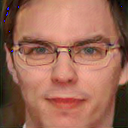

In [18]:
shifted_image = tensor_to_image(inverse(image, shift * 2))
shifted_image

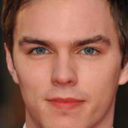

In [19]:
image

In [19]:
tensor = image_to_tensor(shifted_image)

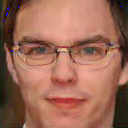

In [20]:
cleared_image = (tensor - tensor.min())/(tensor.max() - tensor.min())
tensor_to_image(cleared_image)

## Шаг 9: улучшение результата

Как вы могли заметить, в результате оптимизации полученные изображения, хоть и приобретают желаемые черты, становятся несколько неестественными (изменяется цвет, добавляется сильно размытие). То есть становятся сильно отличающимися от исходных изображений. 

В статье рассматривается эта проблема, а так же приводится её решение.

### Задача

**Реализуйте функцию inverse_improved, которая позволяет бороться с появление подобных нежелательных эффектов.** Внутри этой функции вы можете вызывать уже имеющуюся функцию `inverse`.

Специальный метод подбора коэффициента интерполяции $\alpha$: $$\phi(z) = \phi(x) + \alpha w$$

$$\alpha = \frac{\beta}{\frac{1}{D}\sum_d w_d^2}$$

In [20]:
def inverse_improved_old(image, shift):
    alpha = 5e4 / np.mean(shift**2)
    return inverse(image, alpha*shift)

In [21]:
def inverse_improved(image, shift):
    _rec = inverse(image, np.zeros_like(shift))
    alpha = 5e4 / np.mean(shift**2)
    _new = inverse(image, alpha * shift)    # alpha * shift?
    _src = image_to_tensor(image)
    _fix = _new - (_rec - _src)
    _fix = np.clip(_fix, 0, 1)
    return _fix

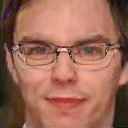

In [22]:
improved_shifted_image = tensor_to_image(inverse_improved_old(image, shift))
improved_shifted_image

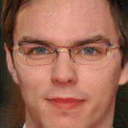

In [23]:
improved_shifted_image = tensor_to_image(inverse_improved(image, 2 * shift))
improved_shifted_image

In [24]:
alpha = 5e4 / np.mean(shift**2)
alpha

2.6818801907738714

In [25]:
improved_shifted_image.save('glasses.png')

Полученное изображение выглядит более естественно.

## Шаг 10: движение в пространстве

### Задача

Попробуйте произвести интерполяцию сразу по двум направлениям. То есть **варьируя параметр alpha для каждого из направлений, постройте двумерный массив изображений**.

Следуя статье, здесь я исследовал зависимость качества преобразования от двух параметров: сила интерполяции $\alpha$. И число ближайших соседей $k$ для составлении связанный выборок $S_1$ и $S_2$ для рассчёта сдвига $w = \bar{\phi}(S_1) - \bar{\phi}(S_2)$

In [ ]:
images = list()
for k in (1, 100, 1000):
    shift = get_shift(
        image,
        k,
        source_params=dict(
            age=list(map(str, range(18, 40))),
            gender='male',
            race='caucasian',
            glasses='no',
            facial_hair='shaved'
        ), 
        target_params=dict(
            age=list(map(str, range(18, 40))),
            gender='male',
            race='caucasian',
            glasses='usual',
            facial_hair='shaved'
        )
    )
    for alpha in (0.2, 0.5, 1, 1.5):
        images.append(inverse(image, alpha*shift))

100%|██████████| 1/1 [00:00<00:00, 123.38it/s]


In [ ]:
images = np.vstack(images)

In [ ]:
plt.figure(figsize=(10, 4))
for j, image in enumerate(images):
    plt.subplot(3, 4, j + 1)
    plt.imshow((image*255).astype(np.uint8))
    plt.xticks([])
    plt.yticks([])

По вертикальной оси $k = (1, 100, 1000)$

По горизонтальной оси $\alpha = (0.2, 0.5, 1, 1.5)$

С ростом коэффициента $\alpha$ усиливается эффект нового атрибута, но в то же время при большом $\alpha$ могут проявлятся артефакты, что соответствует большому шуму в модели. Большое число ближайших соседей $k$ позволяет получить более качественную картинку за счёт долгого времени работы. Было принято решения оставить $k=400$ изображений.

## Шаг 11: работа с произвольными изображениями

Как вы могли заметить, до этого момента мы эксперементировали только с изображениями из предоставленной базы. Эти изображения унифицированы (то есть приведены к общему виду: одинаковый кроп, выравнивание). А хотелось бы модифицировать изображения лиц не только из этой базы. Для этого нужно научиться извлекать изображение лица из фотографии.

Воспользуемся наиболее простым способом, а именно: реализацией каскадов Хаара из библиотеки OpenCV. Поскольку мы сможем обнаруживать лица, но сможем их выравнивать, желательно, чтобы лица уже находились в выровненном положении.

### Задача

**Воспользуясь документацией, разберитесь, как нужно работать с cv2.CascadeClassifier.** Параметры каскада прилагаются к архиву.

In [26]:
HAAR_CASCADE_FILEPATH = './data/params/haarcascade_frontalface_default.xml'
cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILEPATH)

def get_face_bbox(image):
    x, y, w, h = cascade.detectMultiScale(np.array(image))[0]
    return x, y, x + w, y + h

def get_face_image(image):
    bbox = get_face_bbox(image)
    image = image.crop(bbox)
    image = image.resize((128, 128), Image.BICUBIC)
    image = image.convert("RGB")
    return image, bbox

### Задача

Реализуйте функцию вставки лица обратно в изображение. Обратите внимание, что если просто вставлять картинку обратно в изображение, результат появляется очень неестествненый: на границах проявляется явное нессответствие цветов пикселей. Придумайте несложное решение для обхода этой проблемы.

Нам рассказывали на лекциях, что нужно учесть градиенты на границах bbox(image) и face_image, но не знаю точно, как это сделать, поэтому применил простое сглаживание.

x, y, x+h, y+h

In [27]:
from PIL import ImageFilter

In [28]:
def paste_face_back(image, face_image, bbox):
    face_image = face_image.resize((bbox[3] - bbox[1], bbox[2] - bbox[0]), Image.BICUBIC)
    image = image.copy()
    image.paste(face_image, bbox)
    return image.filter(ImageFilter.SMOOTH)

### Финальный результат

Продемонстрируйте работу вашего алгоритма на изображении любого человека.

In [69]:
shift = get_shift(
    image, 
    kneighbors=200,
    source_params=dict(
        age=list(map(str, range(18, 25))),
        gender='male',
        race='caucasian',
        glasses='usual',
        facial_hair='shaved'
    ), 
    target_params=dict(
        age=list(map(str, range(18, 25))),
        gender='male',
        race='caucasian',
        glasses='no',
        facial_hair='shaved'
    )
)
np.save('shift4', shift)

100%|██████████| 200/200 [00:01<00:00, 148.54it/s]


In [70]:
source_image = Image.open('IMG_0859.JPG')
#source_image = source_image.rotate(-90, expand=True)
source_image = source_image.resize(
    (source_image.width // 4, source_image.height // 4), Image.BICUBIC)

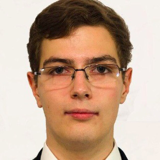

In [71]:
source_image

In [72]:
shift = np.load('shift4.npy')

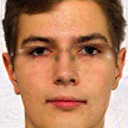

In [73]:
face_image, bbox = get_face_image(source_image)
face_image_tensor = inverse_improved(face_image, shift)
face_image = tensor_to_image(face_image_tensor)
face_image

In [74]:
face_image_tensor_2 = image_to_tensor(face_image)
face_image_tensor_2.max(), face_image_tensor_2.min()

(1.0, 0.0)

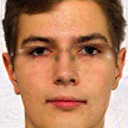

In [75]:
clear_face_image_tensor_2 = ((face_image_tensor_2 - face_image_tensor_2.min())/
    (face_image_tensor_2.max() - face_image_tensor_2.min()))
tensor_to_image(face_image_tensor_2)

In [76]:
face_image_tensor.max(), face_image_tensor.min()

(1.0, 0.0)

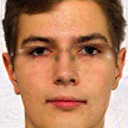

In [77]:
clear_face_image_tensor = ((face_image_tensor - face_image_tensor.min())
    /(face_image_tensor.max() - face_image_tensor.min()))
clear_face_image = tensor_to_image(clear_face_image_tensor)
clear_face_image

In [78]:
target_image = paste_face_back(source_image, face_image, bbox)
result = Image.new("RGB", (source_image.width * 2, source_image.height))
result.paste(source_image, (0, 0))
result.paste(target_image, (source_image.width, 0))
result.save('roma.png')

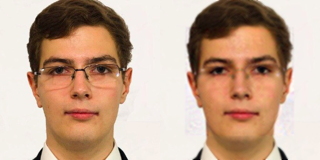

In [79]:
result

## Заключение

В данной работе удалось реализовать алгоритм переноса стиля на основе нейросетевых эмбеддингов: Deep Feature Interpolation. Его ещё нужно настраивать, убирать артефакты, аккуратней сглаживать границы встраиваемых изображений, но в целом -- он работает.